In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

data_dir = './hamiltonisland-data'
train_dir = os.path.join(data_dir, 'train/')
validation_dir = os.path.join(data_dir, 'validation/')

classes = ['disabled', 'published']




In [2]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),    
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
validation_data = datasets.ImageFolder(validation_dir, transform=data_transform)

print('Num training images: ', len(train_data))
print('Num validation images: ', len(validation_data))

Num training images:  1122
Num validation images:  206


In [3]:
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

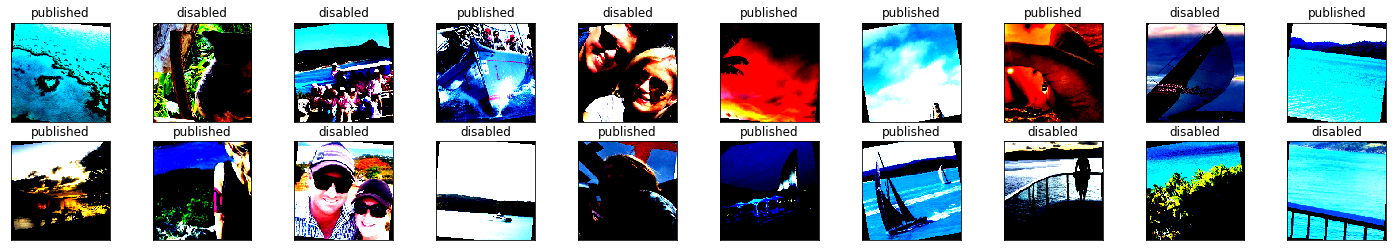

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [5]:
# Load the pretrained model from pytorch
model = models.mobilenet_v2(pretrained=True)

# print out the model structure
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [6]:
for param in model.features.parameters():
    param.requires_grad = False


In [7]:
import torch.nn as nn

n_inputs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(n_inputs, len(classes))

print(model)


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [8]:
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [9]:
import torch.optim as optim

if train_on_gpu:
    model.cuda()

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)


# number of epochs to train the model
n_epochs = 10


for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 0.6929703801870346
Epoch 1, Batch 40 loss: 0.6713215053081513
Epoch 2, Batch 20 loss: 0.6615268528461457
Epoch 2, Batch 40 loss: 0.6654514819383621
Epoch 3, Batch 20 loss: 0.6428383857011795
Epoch 3, Batch 40 loss: 0.6374490022659302
Epoch 4, Batch 20 loss: 0.6291402876377106
Epoch 4, Batch 40 loss: 0.6010053306818008
Epoch 5, Batch 20 loss: 0.6001621678471565
Epoch 5, Batch 40 loss: 0.6269642651081085
Epoch 6, Batch 20 loss: 0.6121783107519150
Epoch 6, Batch 40 loss: 0.6362197265028954
Epoch 7, Batch 20 loss: 0.6109079629182815
Epoch 7, Batch 40 loss: 0.5986470296978951
Epoch 8, Batch 20 loss: 0.6302875578403473
Epoch 8, Batch 40 loss: 0.5782272249460221
Epoch 9, Batch 20 loss: 0.5917920351028443
Epoch 9, Batch 40 loss: 0.6204833269119263
Epoch 10, Batch 20 loss: 0.5978373944759369
Epoch 10, Batch 40 loss: 0.6107884466648101


In [10]:
train_on_gpu = True
# track test loss 
# over 2 classes
test_loss = 0.0
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))




model.eval() # eval mode


for data, target in validation_loader:
    # move tensors to GPU if CUDA is available
    # forward pass: compute predicted outputs by passing inputs to the model
    if train_on_gpu:
            data, target = data.cuda(), target.cuda()

    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)    
    test_loss += loss.item()*data.size(0)    
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(target.data.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        
test_loss = test_loss/len(validation_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))        

Test Loss: 0.640456

Test Accuracy of disabled: 60% (66/109)
Test Accuracy of published: 69% (67/97)

Test Accuracy (Overall): 64% (133/206)


In [11]:
torch.save(model.state_dict(), 'mobilenet-pytorch-hamiltonisland.pth')
